# Continuous Advantage-Critic Model in Tensorflow 2.0

#### Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import numpy as np

### Policy and Value Classes

#### Discrete case
The agent reads the state and produces two values: 
- Action to be taken 
- Estimate of its future rewards given the current state (i.e - the equivalent of the value of the Q-table)

The action is sampled from a discrete distribution where probabilities of the different actions are estimated by the network ('logits')

In [2]:
class DiscreteDistribution(tf.keras.Model):
    # Sample a random action from the given logits.
    def call(self, logits, **kwargs):
        return tf.random.categorical(logits, 1)

class DiscreteAgent(tf.keras.Model):
    def __init__(self, num_actions, hidden_units=64):
        super(DiscreteAgent,self).__init__('discrete_agent')
        self.hidden1 = layers.Dense(hidden_units, activation='relu')
        self.hidden2 = layers.Dense(hidden_units, activation='relu')
        self.logits = layers.Dense(num_actions, name='policy_logits')
        self.value = layers.Dense(1, name='value')
        self.dist = DiscreteDistribution()        
    
    def call(self, inputs, training=None):
        x = tf.convert_to_tensor(inputs)
        logs = self.hidden1(x)
        vals = self.hidden2(x)
        return self.logits(logs), self.value(vals)

    def action_value(self, obs):
        logits, value = self(obs)
        action = self.dist(logits)
        return np.squeeze(action.numpy()), np.squeeze(value.numpy())

#### Continuous case

The continuous case is similr in structure to the discrete case. The agent reads the state and produces two values:
- Action to be taken 
- Estimate of its future rewards given the current state (i.e - the equivalent of the value of the Q-table)

The only difference is that the action is sampled from a gaussian distribution with a given mean and variance.
<br>The mean and the variance are estimated by the network (like the logits in the discrete case).
<br>Finally and 'tanh' function is applied to the action space so that actions are normalized between -1 and 1.

In [217]:
class ContinuousDistribution(tf.keras.Model):
    # Sample a random action from the given logits.
    def call(self, mean, var, **kwargs):
        actions = [tf.tanh(tf.random.normal((1,),m,v)) for m,v in zip(mean,var)]
        return tf.stack(actions,axis=0)

class ContinuousAgent(tf.keras.Model):
    def __init__(self, num_actions=1, hidden_units=64):
        super(ContinuousAgent,self).__init__('continuous_agent')
        self.hidden1 = layers.Dense(hidden_units, activation='relu')
        self.hidden2 = layers.Dense(hidden_units, activation='relu')
        self.mean = layers.Dense(num_actions, name='policy_means')
        self.var = layers.Dense(num_actions, name='policy_vars',activation='sigmoid')
        self.value = layers.Dense(1, name='value')
        self.dist = ContinuousDistribution()        
    
    def call(self, inputs, training=None):
        x = tf.convert_to_tensor(inputs)
        logs = self.hidden1(x)
        vals = self.hidden2(x)
        return self.mean(logs), self.var(logs), self.value(vals)

    def action_value(self, obs):
        mean,var,value = self(obs)
        action = self.dist(mean,var)
        return np.squeeze(action.numpy()), np.squeeze(value.numpy())

#### Basic Test

In [218]:
state = [[0.1,0.5],[0.5,-0.6]]
cagent = ContinuousAgent(1)
a,p = cagent.action_value(state)
print('Actions:{}, Payoffs:{}'.format(a,p))
dagent = DiscreteAgent(5)
a,p = dagent.action_value(state)
print('Actions:{}, Payoffs:{}'.format(a,p))


Actions:[ 0.0017717  -0.49248543], Payoffs:[0.03926148 0.05046482]
Actions:[3 2], Payoffs:[-0.02423801  0.07189786]


### Define Environment -  Power Market Dynamics
Here we define the dynamic of the Power market.
<br> In this basic examples I've defined the State to be just the Price. The price evolves as function of agent's actions following a simple rule:
<br> $P(t+1) = P(t)*e^{\sum{actions}}$
<br> The 'reward' for every action is also defined simply:
<br> $r = (P(t+1)-P(t))*action$

In [203]:
class PowerMarket:
    def __init__(self, max_episodes, initial_state=[1.], price_lim = [0.1,10]):
        self.max_episodes = max_episodes
        self.episode = 0                
        self.initial_state = np.atleast_1d(initial_state)
        self.state = self.initial_state
        self.state_size = self.initial_state.shape[0]
        self.price_lim = price_lim
    
    def reset(self):
        self.episode = 0
        return self.initial_state
        
    def step(self, actions):
        # Do some maths
        new_state = np.clip(self.state*np.exp(np.sum(actions)), self.price_lim[0], self.price_lim[1])
        rewards = (new_state-self.state)*actions
        self.state = new_state
        self.episode += 1
        if self.episode>=self.max_episodes:
            done=True
        else:
            done=False
        return new_state, rewards, done, []
    

#### Quick dummy test

In [205]:
env = PowerMarket(10,[1.])
i,done = 0,False
while not done:
    i+=1
    s,r,done,_ = env.step([0.1,-0.5])
    print('Episide:{},Price:{}, Rewards:{}'.format(i,s,r))   


Episide:1,Price:[0.67032005], Rewards:[-0.032968    0.16483998]
Episide:2,Price:[0.44932896], Rewards:[-0.02209911  0.11049554]
Episide:3,Price:[0.30119421], Rewards:[-0.01481348  0.07406738]
Episide:4,Price:[0.20189652], Rewards:[-0.00992977  0.04964885]
Episide:5,Price:[0.13533528], Rewards:[-0.00665612  0.03328062]
Episide:6,Price:[0.1], Rewards:[-0.00353353  0.01766764]
Episide:7,Price:[0.1], Rewards:[ 0. -0.]
Episide:8,Price:[0.1], Rewards:[ 0. -0.]
Episide:9,Price:[0.1], Rewards:[ 0. -0.]
Episide:10,Price:[0.1], Rewards:[ 0. -0.]


### Advantage Actor-Critic Class
For a good overview of the different RL methods:
https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html

The following code is based on an implementation of A2C:
http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/


#### Discrete Version

In [206]:
class DiscreteA2C:
    def __init__(self, model, lr=7e-3, gamma=0.99, value_c=0.5, entropy_c=1e-4):
        self.gamma = gamma
        self.value_c = value_c
        self.entropy_c = entropy_c
        self.model = model
        # Model (aka Agent) has two objectives:
        # - Minimise policy loss: find the best policy for actions
        # - Minimise value loss: find the best approximation of the true 'Q-table' (i.e. the value of being in a state)
        self.model.compile(optimizer=optimizers.Adam(lr=lr), loss=[self._logits_loss, self._value_loss])

    def test(self, env, render=False):
        obs, done, ep_reward = env.reset(), False, 0
        while not done:
            action, _ = self.model.action_value(obs[None,:].astype('float32'))
            obs, reward, done, _ = env.step(action)
            ep_reward += reward
        return ep_reward
    
    def train(self, env, batch, updates=20):
        actions = np.empty((batch,), dtype=np.int32)
        rewards, dones, values = np.empty((3, batch))
        #observations = np.empty((batch, env.state_size))
        observations = np.empty((batch,) + env.observation_space.shape)
        # Training loop: collect samples, send to optimizer, repeat 
        ep_rewards = [0.0]
        next_obs = env.reset()
        for update in range(updates):
            for step in range(batch):
                observations[step] = next_obs.copy()
                actions[step], values[step] = self.model.action_value(next_obs[None,:].astype('float32'))
                next_obs, rewards[step], dones[step], _ = env.step(actions[step])

                ep_rewards[-1] += rewards[step]
                if dones[step]:
                    ep_rewards.append(0.0)
                    next_obs = env.reset()
                    if not  len(ep_rewards)%10:
                        print("Episode: %03d, Reward: %03d" % (len(ep_rewards) - 1, ep_rewards[-2]))

            _, next_value = self.model.action_value(next_obs[None, :].astype('float32'))
            returns, advs = self._returns_advantages(rewards,dones, values, next_value)
            acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
            losses = self.model.train_on_batch(observations, [acts_and_advs, returns])

        return ep_rewards

    def _returns_advantages(self, rewards, dones, values, next_value):
        returns = np.append(np.zeros_like(rewards), np.atleast_1d(next_value), axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates that the net produced).
        advantages = returns - values
        return returns, advantages

    def _value_loss(self, returns, value):
        # Value loss: Net learns to proxy the returns through MSE gradients descent
        return self.value_c * losses.mean_squared_error(returns, value)

    def _logits_loss(self, actions_and_advantages, logits):
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        actions = tf.cast(actions, tf.int32)

        # Cross entropy loss - Standard for discrete classfication problems
        weighted_sparse_ce = losses.SparseCategoricalCrossentropy(from_logits=True)
        
        # Net learns to assign high probabilities to good actions. Good actions are defined as the ones with high advantage values.
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        
        # Entropy loss can be calculated as cross-entropy over itself.
        probs = tf.nn.softmax(logits)
        entropy_loss = losses.categorical_crossentropy(probs, probs)
        
        # We want to minimize policy and maximize entropy losses. 
        return policy_loss - self.entropy_c * entropy_loss

#### Test Discrete Agent on Gym Cartpole task

Episode: 009, Reward: 024
Episode: 019, Reward: 012
Episode: 029, Reward: 017
Episode: 039, Reward: 033
Episode: 049, Reward: 021
Episode: 059, Reward: 028
Episode: 069, Reward: 061
Episode: 079, Reward: 080
Episode: 089, Reward: 026
Episode: 099, Reward: 083
Episode: 109, Reward: 045
Episode: 119, Reward: 027
Episode: 129, Reward: 060
Episode: 139, Reward: 061
Episode: 149, Reward: 125
Episode: 159, Reward: 074
Episode: 169, Reward: 200
Episode: 179, Reward: 137
Episode: 189, Reward: 167
Episode: 199, Reward: 116
Episode: 209, Reward: 200
Episode: 219, Reward: 200
Episode: 229, Reward: 200
Episode: 239, Reward: 168
Episode: 249, Reward: 200
Episode: 259, Reward: 134
Episode: 269, Reward: 164
Episode: 279, Reward: 149
Episode: 289, Reward: 139
Episode: 299, Reward: 200
Episode: 309, Reward: 200
Episode: 319, Reward: 200
Episode: 329, Reward: 200
Episode: 339, Reward: 200
Episode: 349, Reward: 200
Episode: 359, Reward: 150
Episode: 369, Reward: 200
Episode: 379, Reward: 200
Episode: 389

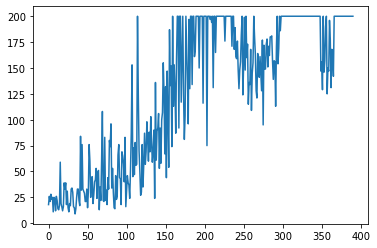

In [123]:
import gym
env = gym.make('CartPole-v0')
dmodel = DiscreteAgent(num_actions=env.action_space.n)
agent = DiscreteA2C(dmodel)
rewards_history = agent.train(env, 200, updates=250)
plt.plot(rewards_history[:-1])

#### Continuous Version

In [222]:
class ContinuousA2C:
    def __init__(self, model, lr=7e-3, gamma=0.99, value_c=0.5, entropy_c=1e-4):
        self.gamma = gamma
        self.value_c = value_c
        self.entropy_c = entropy_c
        self.model = model
        # Model (aka Agent) has two objectives:
        # - Minimise policy loss: find the best policy for actions
        # - Minimise value loss: find the best approximation of the true 'Q-table' (i.e. the value of being in a state)
        self.model.compile(optimizer=optimizers.Adam(lr=lr), 
                        loss=[self._mean_loss, self._var_loss, self._value_loss],
                        loss_weights = [1., self.entropy_c, self.value_c ])

    def test(self, env, render=False):
        obs, done, ep_reward = env.reset(), False, 0
        while not done:
            action, _ = self.model.action_value(obs[None,:].astype('float32'))
            obs, reward, done, _ = env.step(action)
            ep_reward += reward
        return ep_reward
    
    def train(self, env, batch, updates=20):
        actions = np.empty((batch,), dtype=np.float32)
        rewards, dones, values = np.empty((3, batch))
        observations = np.empty((batch, env.state_size))
        #observations = np.empty((batch,) + env.observation_space.shape)
        # Training loop: collect samples, send to optimizer, repeat 
        ep_rewards = [0.0]
        next_obs = env.reset()
        for update in range(updates):
            for step in range(batch):
                observations[step] = next_obs.copy()
                actions[step], values[step] = self.model.action_value(next_obs[None,:].astype('float32'))
                next_obs, rewards[step], dones[step], _ = env.step(actions[step])
                ep_rewards[-1] += rewards[step]
                if dones[step]:
                    ep_rewards.append(0.0)
                    next_obs = env.reset()
                    if not  len(ep_rewards)%10:
                        print("Episode: %03d, Reward: %03d" % (len(ep_rewards) - 1, ep_rewards[-2]))

            _, next_value = self.model.action_value(next_obs[None, :].astype('float32'))
            returns, advs = self._returns_advantages(rewards,dones, values, next_value)
            acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
            losses = self.model.train_on_batch(observations, [acts_and_advs, returns,np.zeros_like(returns)])

        return ep_rewards

    def _returns_advantages(self, rewards, dones, values, next_value):
        returns = np.append(np.zeros_like(rewards), np.atleast_1d(next_value), axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates that the net produced).
        advantages = returns - values
        return returns, advantages

    def _value_loss(self, returns, value):
        # Value loss: Net learns to proxy the returns through MSE gradients descent
        return losses.mean_squared_error(returns, value)

    def _mean_loss(self, actions_and_advantages, mean):
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        actions = tf.cast(actions, tf.int32)
        
        # Weighted MSE in the continuous case
        mse = losses.MeanSquaredError()
        policy_loss = mse(actions, mean, sample_weight=advantages)                
        return policy_loss
    
    def _var_loss(self, _, var):
        entropy_loss = tf.reduce_mean(var)
        # We want to maximize entropy. 
        return -entropy_loss    

#### Test Continuous Agent on dummy Power market

Episode: 009, Reward: 010
Episode: 019, Reward: 000
Episode: 029, Reward: 000
Episode: 039, Reward: 000
Episode: 049, Reward: 001
Episode: 059, Reward: 000
Episode: 069, Reward: 000
Episode: 079, Reward: 000
Episode: 089, Reward: 001
Episode: 099, Reward: 000


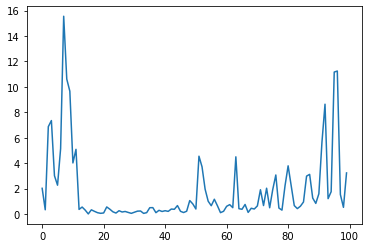

In [227]:
env = PowerMarket(10,[1.])
cmodel = ContinuousAgent(num_actions=1)
agent = ContinuousA2C(cmodel)
rewards_history = agent.train(env, env.max_episodes, updates=100)
plt.plot(rewards_history[:-1])
